**Q2**

In [1]:
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_moons

In [2]:
# --- Data Generation ---
np.random.seed(42)
n_samples = 2000
means = np.array([[-1, -1], [1, 1]])
covariances = [np.array([[1, 0.5], [0.5, 1]]), np.array([[1, -0.5], [-0.5, 1]])]
proportions = [0.5, 0.5]
n_clusters = len(means)

# Generate data
data = []
labels = []
for i, (mean, cov, prop) in enumerate(zip(means, covariances, proportions)):
    n = int(prop * n_samples)
    cluster_data = np.random.multivariate_normal(mean, cov, n)
    data.append(cluster_data)
    labels += [i] * n
data = np.vstack(data)
labels = np.array(labels)

In [3]:
# --- Plotting Utility ---
def plot_clusters(data, labels, centroids=None, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if labels.ndim > 1:
        c=  labels[:,0]
    else:
        c = labels
    ax.scatter(data[:, 0], data[:, 1], c=c, cmap="coolwarm", s=10)
    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], s=300, c="black", marker="X")
    if title is not None:
        ax.set_title(title)

def plot_gaussian_ellipses(means, covariances, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for mean, cov in zip(means, covariances):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(
            xy=mean,
            width=width,
            height=height,
            angle=angle,
            edgecolor="black",
            fc="None",
            lw=2,
        )
        ax.add_patch(ellipse)

In [6]:
# --- KMeans Class ---
class KMeansCustom:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def initialize_centroids(self, data):
        n_samples = data.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = data[indices]

    def assign_clusters(self, data):
        """
        Assign each point to the nearest centroid.
        """

        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        labels = np.argmin(distances, axis=1)


        # labels = np.random.randint(0, self.n_clusters, data.shape[0])
        return labels

    def update_centroids(self, data, labels):
        """
        Update centroids as the mean of all points assigned to each cluster.
        """

        new_centroids = np.zeros((self.n_clusters, data.shape[1]))
        for cluster_idx in range(self.n_clusters):
            cluster_points = data[labels == cluster_idx]

            # Avoid division by zero if a cluster has no points
            if len(cluster_points) > 0:
                new_centroids[cluster_idx] = cluster_points.mean(axis=0)
            else:
                # If no points are assigned, reinitialize the centroid randomly
                new_centroids[cluster_idx] = data[np.random.choice(data.shape[0])]

        # new_centroids = np.random.randn(self.n_clusters, data.shape[1])
        return new_centroids

    def fit(self, data, iterations_to_store=[0, 1, 2, 5, 10, 20]):
        self.initialize_centroids(data)
        self.stored_params = {}
        for i in range(max(iterations_to_store) + 1):
            labels = self.assign_clusters(data)
            new_centroids = self.update_centroids(data, labels)
            if i in iterations_to_store:
                self.stored_params[i] = {
                    "centroids": self.centroids.copy(),
                    "labels": labels.copy(),
                }
            self.centroids = new_centroids

    def predict(self, data):
        return self.assign_clusters(data)

In [11]:
# --- EM Class ---
class EMGMM:
    def __init__(self, n_components):
        self.n_components = n_components

    def initialize_params(self, data):
        n_samples, n_features = data.shape
        self.means = data[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.eye(n_features)] * self.n_components)
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, data):
        """
        Compute responsibilities (soft assignments) for each cluster.
        """
        
        n_samples = data.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self.multivariate_gaussian(
                data, self.means[k], self.covariances[k]
            )

        # Normalize responsibilities across components for each sample
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities
    
        # return np.random.rand(data.shape[0], self.n_components)

    def m_step(self, data, responsibilities):
        """
        Update means, covariances, and weights based on responsibilities.
        """

        n_samples = data.shape[0]
        effective_n = responsibilities.sum(axis=0)

        # Update means
        self.means = (responsibilities.T @ data) / effective_n[:, np.newaxis]

        # Update covariances
        for k in range(self.n_components):
            diff = data - self.means[k]
            weighted_sum = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff
            self.covariances[k] = weighted_sum / effective_n[k]

        # Update weights
        self.weights = effective_n / n_samples



    def multivariate_gaussian(self, data, mean, cov):
        """
        Compute the multivariate Gaussian probability density.
        """

        n_features = data.shape[1]
        cov_inv = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)
        normalization = (2 * np.pi) ** (-n_features / 2) * det_cov ** -0.5
        diff = data - mean
        exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
        
        return normalization * exp_term


    def fit(self, data, iterations_to_store=[0, 1, 2, 5, 10, 20]):
        self.initialize_params(data)
        self.stored_params = {}
        for i in range(max(iterations_to_store) + 1):
            responsibilities = self.e_step(data)
            self.m_step(data, responsibilities)
            if i in iterations_to_store:
                self.stored_params[i] = {
                    "means": self.means.copy(),
                    "covariances": self.covariances.copy(),
                    "responsibilities": responsibilities.copy(),
                }

    def predict(self, data):
        responsibilities = self.e_step(data)
        return np.argmax(responsibilities, axis=1)

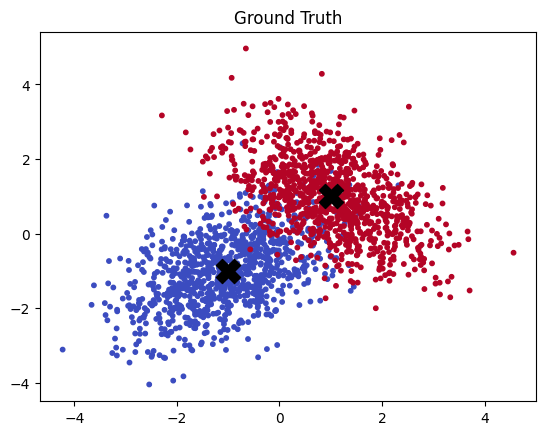

In [12]:
# --- Example Usage ---
# Plot initial data
plot_clusters(data, labels, means, title="Ground Truth")

In [13]:
# Run k-means
kmeans = KMeansCustom(n_clusters=n_clusters)
kmeans.fit(data)
kmeans_labels = kmeans.predict(data)

# Metrics
ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
print(f"k-means ARI: {ari_kmeans:.3f}")

k-means ARI: 0.704


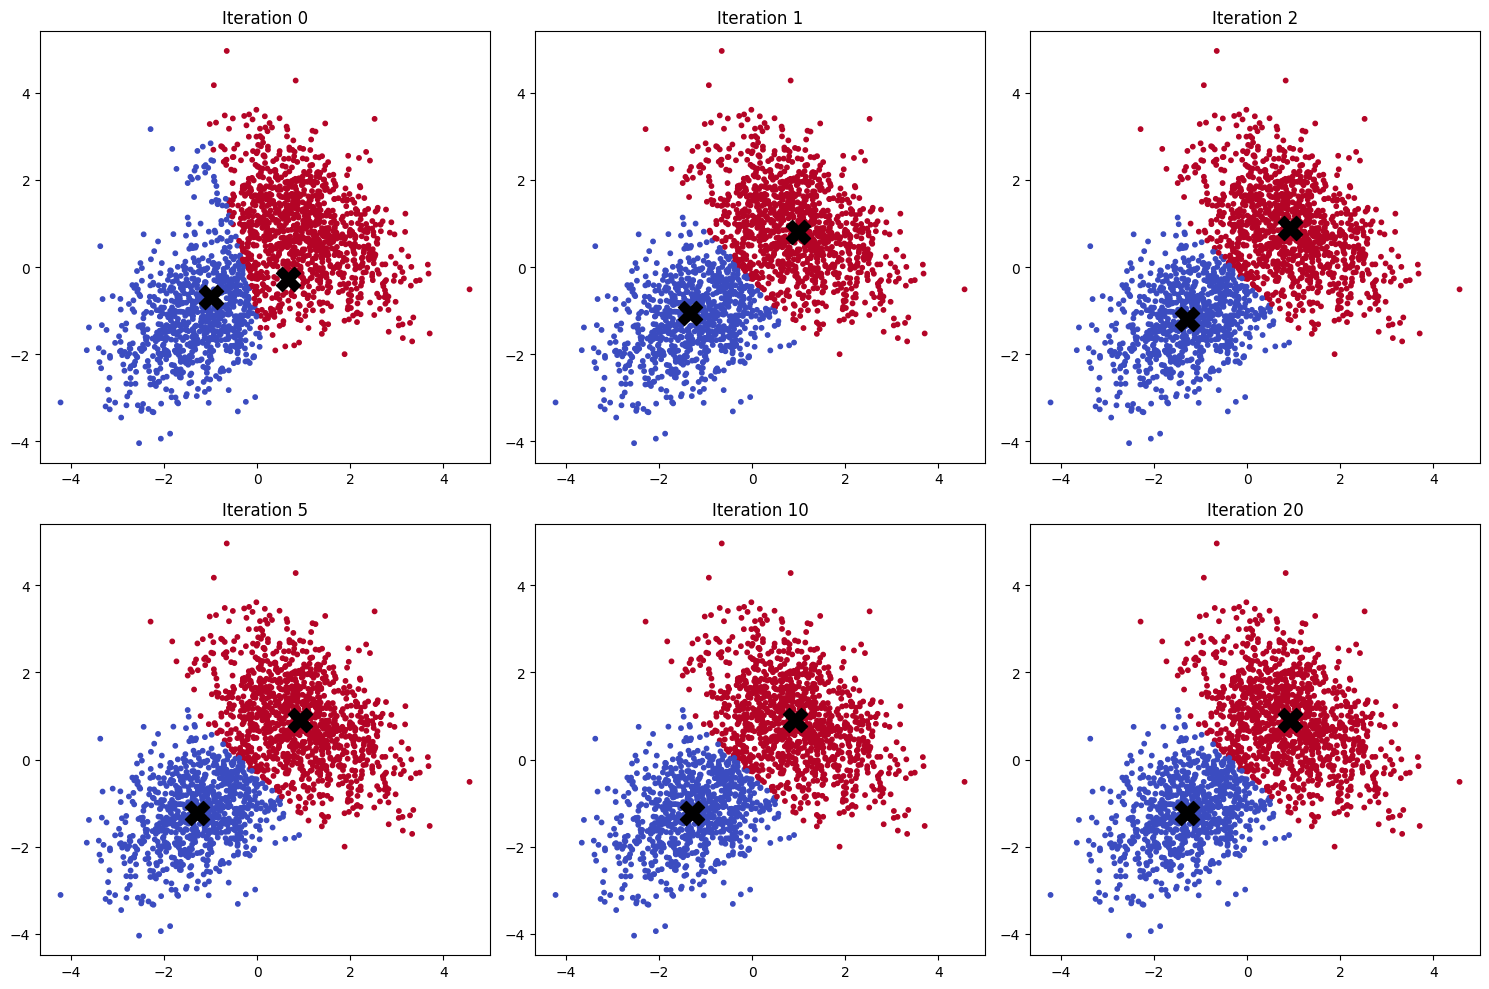

In [14]:
iterations = [0, 1, 2, 5, 10, 20]
# Plot assignments at specified iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = kmeans.stored_params[i]["labels"]
    em_centroids = kmeans.stored_params[i]["centroids"]
    plot_clusters(data, responsibilities, em_centroids, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()

In [15]:
# Run EM
em = EMGMM(n_components=n_clusters)
em.fit(data)
em_labels = em.predict(data)

# Metrics
ari_em = adjusted_rand_score(labels, em_labels)
print(f"EM ARI: {ari_em:.3f}")

EM ARI: 0.773


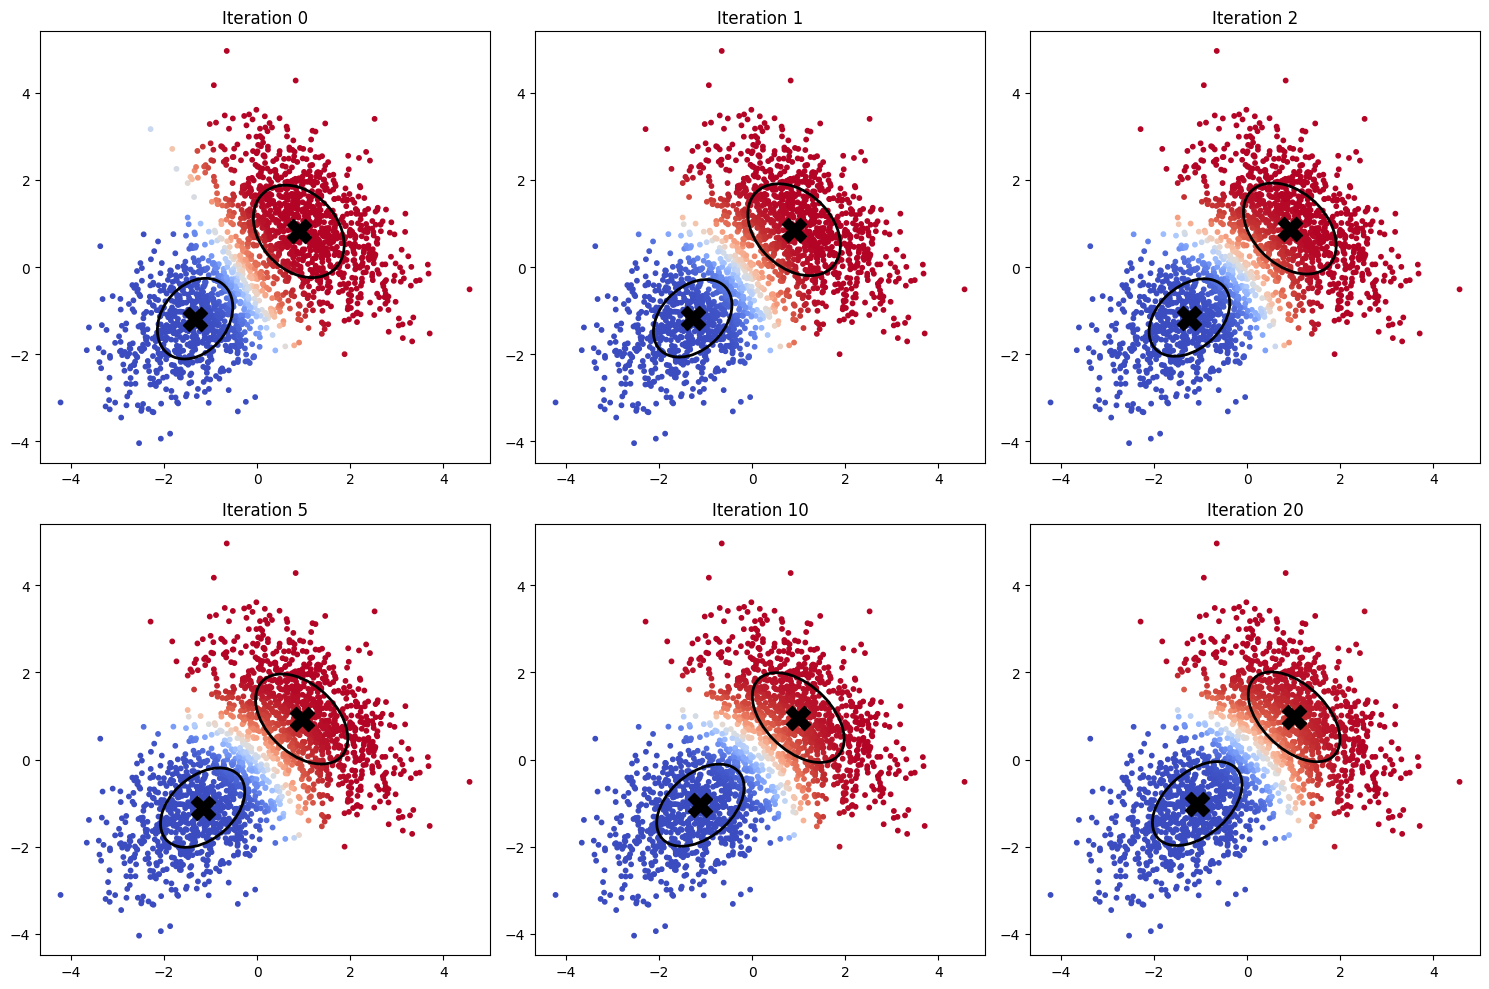

In [16]:
iterations = [0, 1, 2, 5, 10, 20]
# Plot assignments at specified iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = em.stored_params[i]["responsibilities"]
    cov = em.stored_params[i]["covariances"]
    em_centroids = em.stored_params[i]["means"]
    plot_clusters(data, responsibilities, em_centroids, ax=ax)
    plot_gaussian_ellipses(em_centroids, cov, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()

[0.7037760160681025, 0.3820680508910032, 0.20124753127905373]
[0.7620101656872891, 0.6293652349712814, 0.23284048118787148]


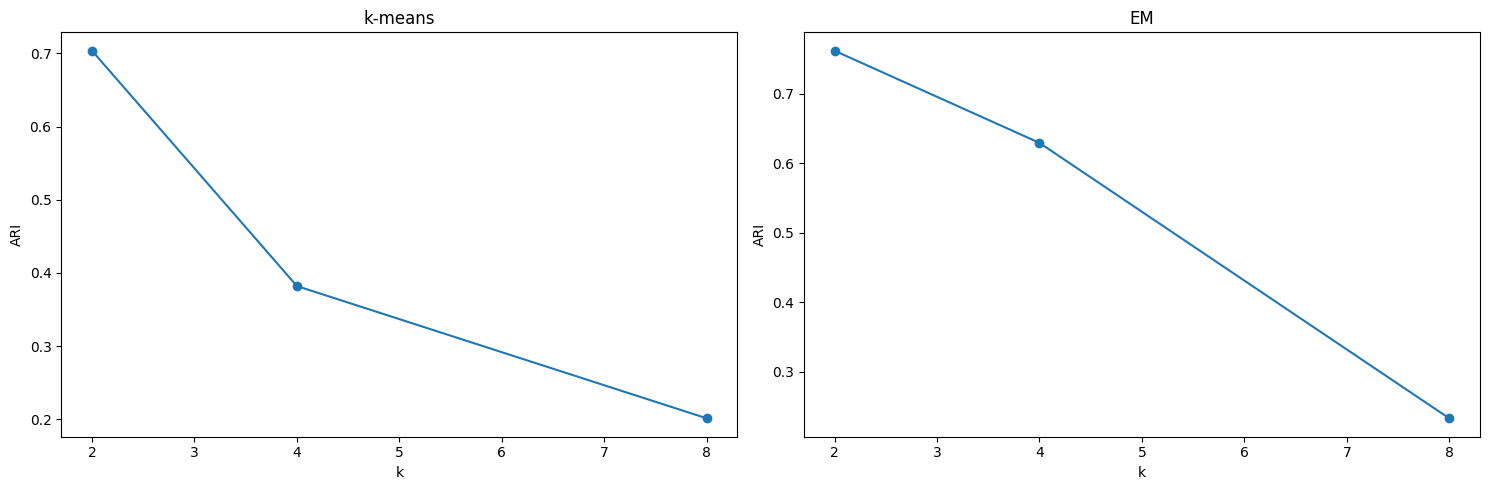

In [30]:
# --- Q5: The Effect of Overestimating Clusters ---

# TODO: # Fill in the code to run k-means and EM with different values of k and plot the results and ARI scores.

iterations_to_store = [0, 1, 2, 5, 10, 20]

k_values = [2, 4, 8]
ari_kmeans_values = []
ari_em_values = []

for k in k_values:
    # Run k-means
    kmeans = KMeansCustom(n_clusters=k)
    kmeans.fit(data)
    kmeans_labels = kmeans.predict(data)

    ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
    ari_kmeans_values.append(ari_kmeans)

    # Run EM
    em = EMGMM(n_components=k)
    em.fit(data)
    em_labels = em.predict(data)

    ari_em = adjusted_rand_score(labels, em_labels)
    ari_em_values.append(ari_em)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(k_values, ari_kmeans_values, marker="o")
axes[0].set_title("k-means")
axes[0].set_xlabel("k")
axes[0].set_ylabel("ARI")

axes[1].plot(k_values, ari_em_values, marker="o")
axes[1].set_title("EM")
axes[1].set_xlabel("k")
axes[1].set_ylabel("ARI")

plt.tight_layout()
print(ari_kmeans_values)
print(ari_em_values)

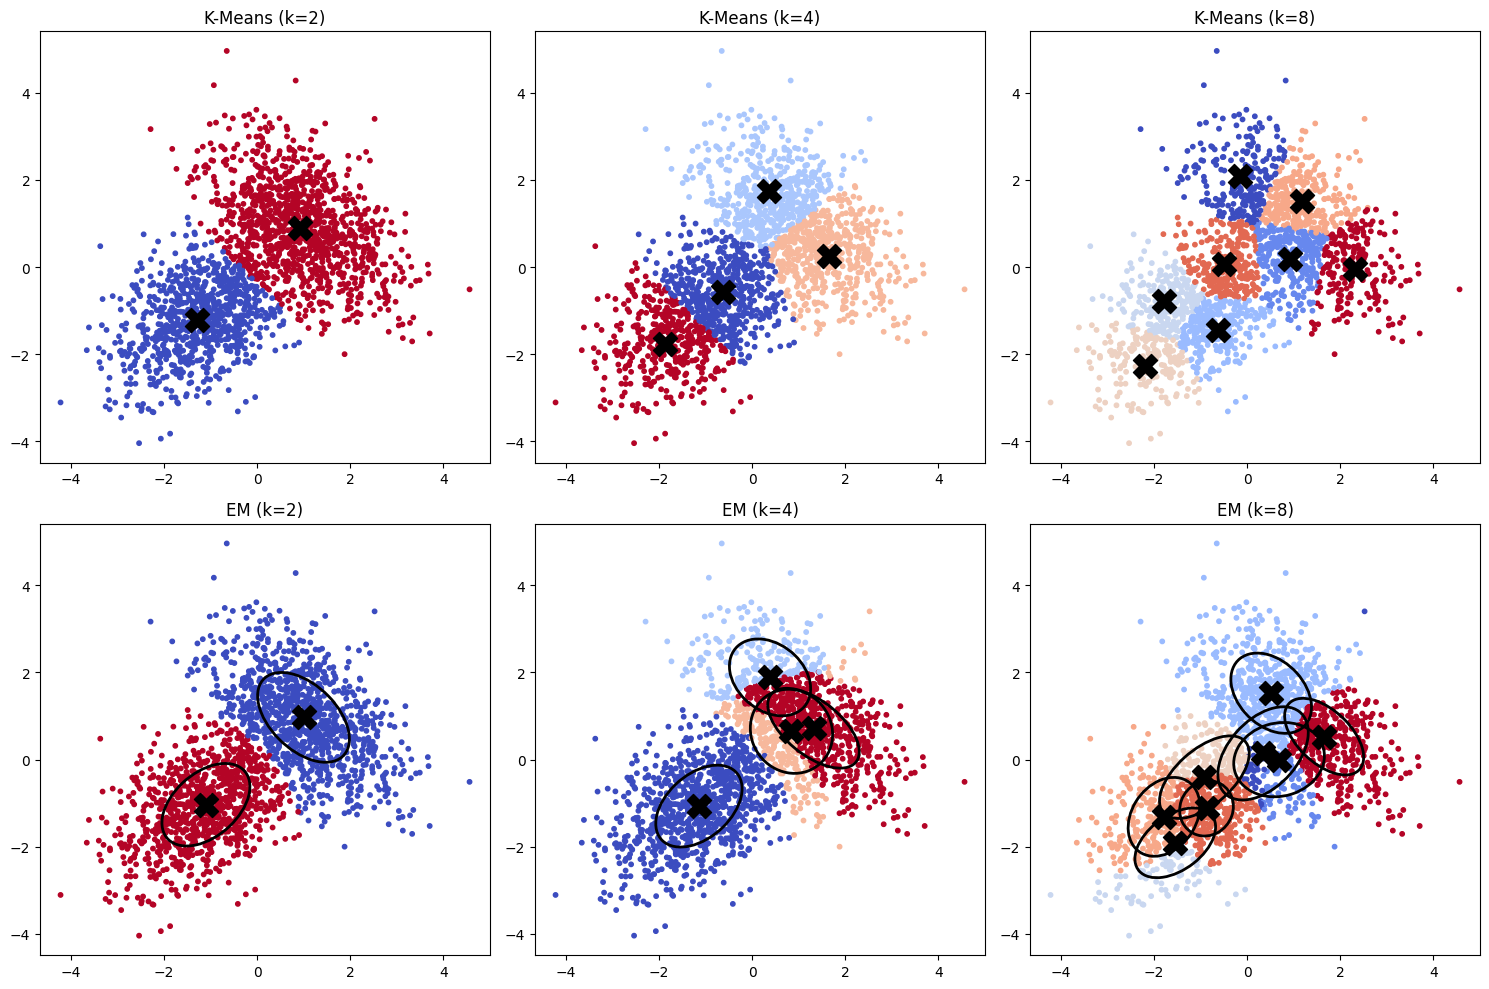

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (method, k) in zip(axes.flatten(), [("K-Means", k) for k in k_values] + [("EM", k) for k in k_values]):
    if method == "K-Means":
        kmeans = KMeansCustom(n_clusters=k)
        kmeans.fit(data)
        kmeans_labels = kmeans.predict(data)
        centroids = kmeans.centroids

        plot_clusters(data, kmeans_labels, centroids=centroids, title=f"{method} (k={k})", ax=ax)

    elif method == "EM":
        em = EMGMM(n_components=k)
        em.fit(data)
        em_labels = em.predict(data)
        means = em.means
        covariances = em.covariances

        plot_clusters(data, em_labels, centroids=means, title=f"{method} (k={k})", ax=ax)
        plot_gaussian_ellipses(means, covariances, ax=ax)

plt.tight_layout()

ari kmeans:  [0.241684666315992, 0.27235052330086124]
ari em:  [0.3645327259189927, 0.2795087590225678]


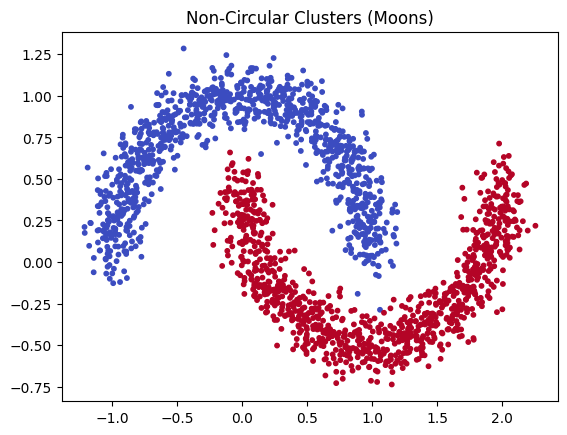

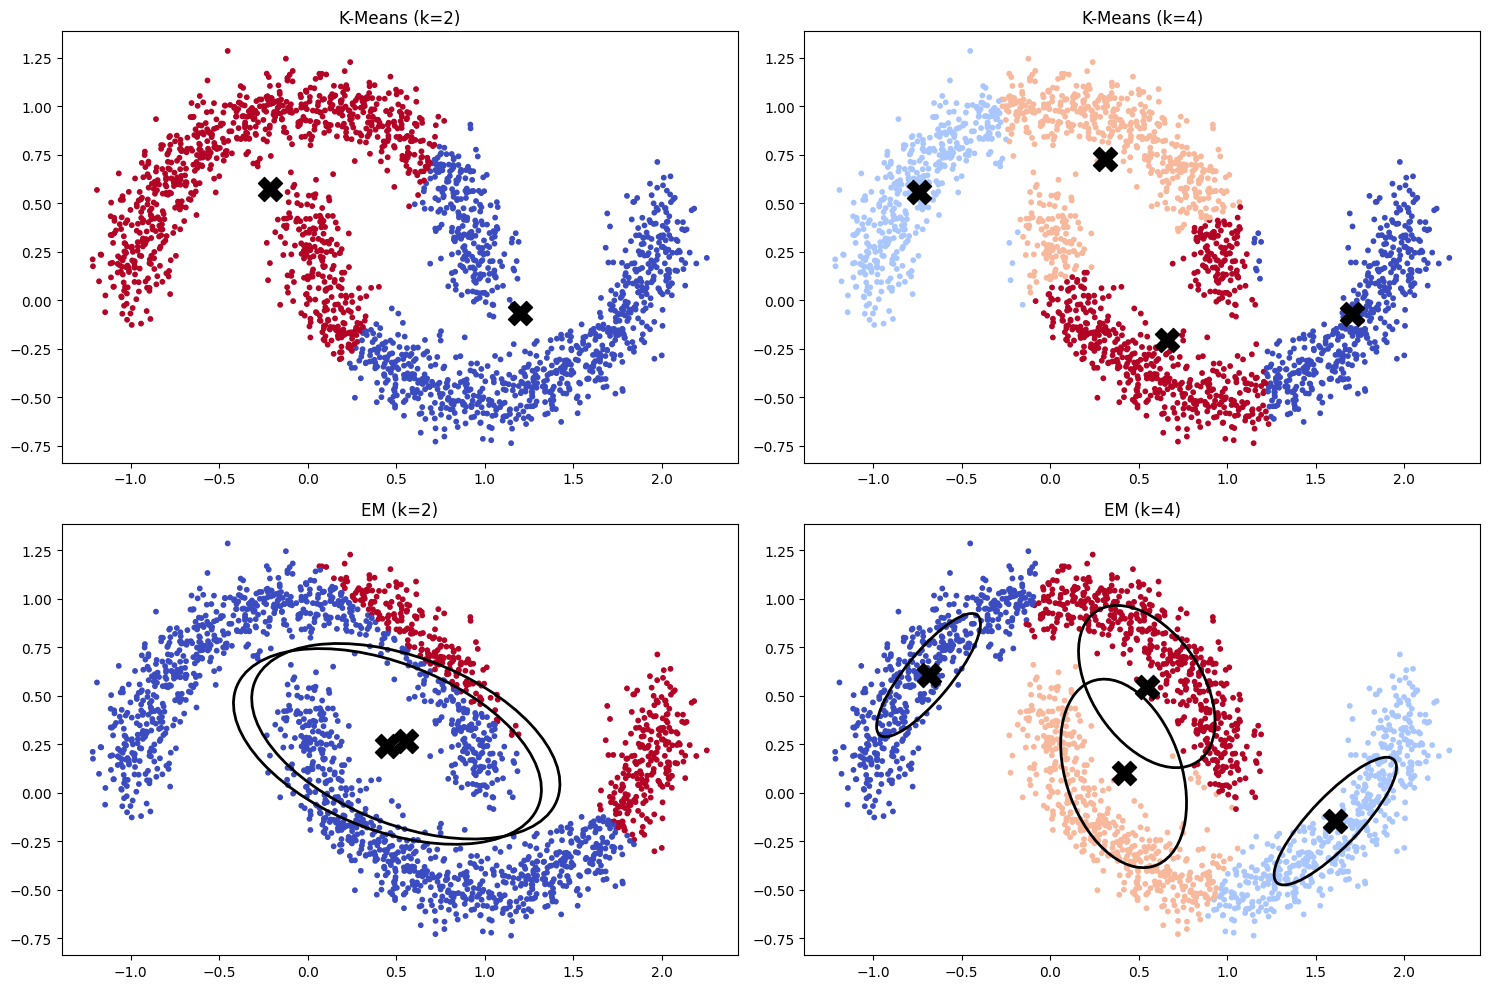

In [32]:
# --- Q6: Non-Circular Clusters (make_moons) ---
def generate_moons_data():
    data, labels = make_moons(n_samples=2000, noise=0.1, random_state=42)
    return data, labels

moons_data, moons_labels = generate_moons_data()
plot_clusters(moons_data, moons_labels, title="Non-Circular Clusters (Moons)")

# TODO: # Fill in the code to run k-means and EM on the moons dataset for k = 2 and 4 clusters and plot the results

k_values = [2, 4]
ari_kmeans_values = []
ari_em_values = []

for k in k_values:
    # Run k-means
    kmeans = KMeansCustom(n_clusters=k)
    kmeans.fit(moons_data)
    kmeans_labels = kmeans.predict(moons_data)

    ari_kmeans = adjusted_rand_score(moons_labels, kmeans_labels)
    ari_kmeans_values.append(ari_kmeans)

    # Run EM
    em = EMGMM(n_components=k)
    em.fit(moons_data)
    em_labels = em.predict(moons_data)

    ari_em = adjusted_rand_score(moons_labels, em_labels)
    ari_em_values.append(ari_em)


# plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for ax, (method, k) in zip(axes.flatten(), [("K-Means", k) for k in k_values] + [("EM", k) for k in k_values]):
    if method == "K-Means":
        kmeans = KMeansCustom(n_clusters=k)
        kmeans.fit(moons_data)
        kmeans_labels = kmeans.predict(moons_data)
        centroids = kmeans.centroids

        plot_clusters(moons_data, kmeans_labels, centroids=centroids, title=f"{method} (k={k})", ax=ax)

    elif method == "EM":
        em = EMGMM(n_components=k)
        em.fit(moons_data)
        em_labels = em.predict(moons_data)
        means = em.means
        covariances = em.covariances

        plot_clusters(moons_data, em_labels, centroids=means, title=f"{method} (k={k})", ax=ax)
        plot_gaussian_ellipses(means, covariances, ax=ax)

plt.tight_layout()
print('ari kmeans: ', ari_kmeans_values)
print('ari em: ', ari_em_values)

**Q3**

(-0.5, 1023.5, 1023.5, -0.5)

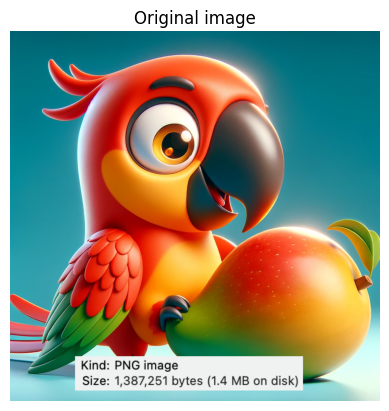

In [51]:
import matplotlib.pyplot as plt
from skimage import io
from sklearn.cluster import KMeans
import numpy as np

image_path = 'Macaw.webp'
image = io.imread(image_path)

plt.imshow(image)
plt.title('Original image')
plt.axis('off')

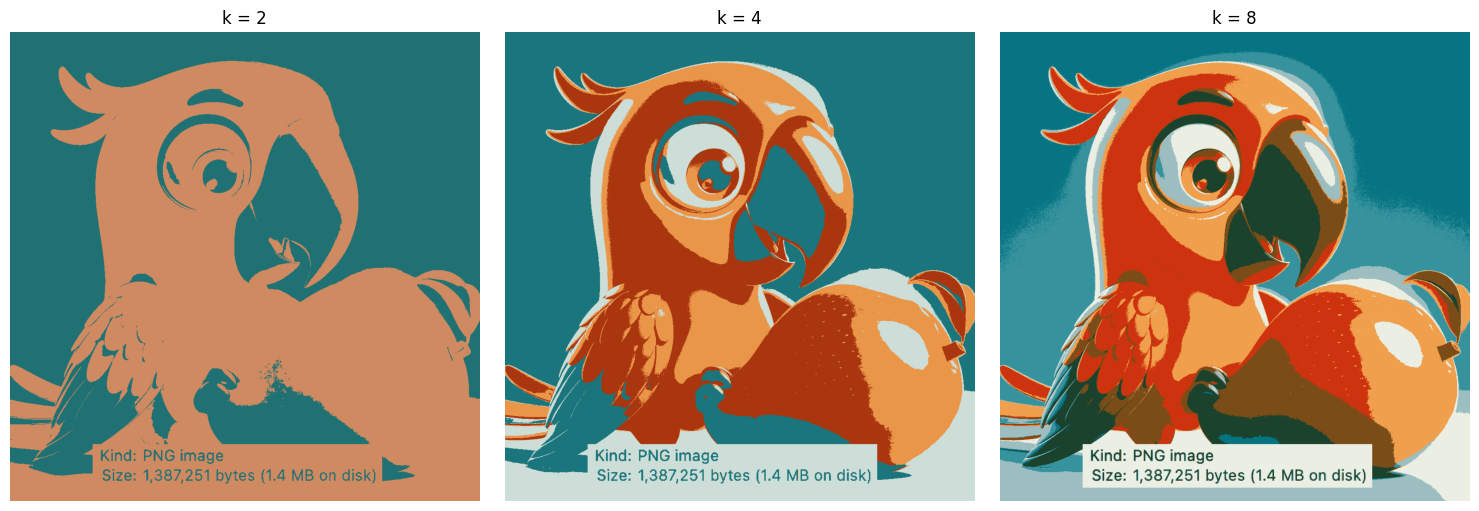

In [58]:
flattened_image = image.reshape(-1, 3)
flattened_image.shape

k_values = [2, 4, 8]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate(k_values):
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state = 3)
    kmeans.fit(flattened_image)
    
    # Get the labels (which cluster each pixel belongs to)
    labels = kmeans.predict(flattened_image)
    
    # Reshape labels back to the original image shape
    clustered_image = labels.reshape(image.shape[0], image.shape[1])
    
    # Replace each pixel with the centroid of its cluster
    segmented_image = kmeans.cluster_centers_[labels].reshape(image.shape)
    
    # Plot the result
    axes[i].imshow(segmented_image.astype(np.uint8))  # Convert to uint8 for display
    axes[i].set_title(f'k = {k}')
    axes[i].axis('off')

plt.tight_layout()